In [3]:
### load modules 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re 
import pickle
import pingouin as pg
from itertools import groupby
from operator import itemgetter

### load my scripts 
import data_combiner as dc
import plotting_funcs as pf
import sim as sim


plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('paper',font_scale=2)
plt.rcParams["lines.linewidth"] = 3

plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Verdana'

save_plots = False

## 1. Load and clean data 

In [5]:
all_filenames = glob.glob("data/*.csv")
all_data = dc.clean_data_group(all_filenames).reset_index(drop=True)

num_subs = len(list(set(all_data['sub_num'])))
subs = list(set(all_data.sub_num.tolist()))

rt_df = dc.make_rt_df(subs, all_data)

ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-05-24_20h19.50.920.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-03-22_19h35.18.739.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-05-24_20h19.35.387.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-04-17_22h57.16.765.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-03-25_16h01.26.340.csv
ERROR in loading and cleaning the raw data file
data/~$space_foraging_PARTICIPANT_SESSION_2023-05-31_13h19.06.385.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-03-27_21h41.44.829.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PARTICIPANT_SESSION_2023-05-25_12h53.41.604.csv
ERROR in loading and cleaning the raw data file
data/space_foraging_PA

### 1a. save data in format for modeling

In [6]:
dc.transform_data_for_modeling(all_data)

/Users/nharhen/Desktop/Projects/foraging/Harhen-Hartley-Bornstein-2025/data_analysis/data_combiner.py:423: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for planet in block_planets[:-1]: # don't include the last planet because time on planet ends mid planet
/Users/nharhen/Desktop/Projects/foraging/Harhen-Hartley-Bornstein-2025/data_analysis/data_combiner.py:423: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for planet in block_planets[:-1]: # don't include the last planet because

### 1b. Drop subs who fail exclusion criteria

#### Helper functions

In [7]:
def find_extreme_overharvesters(df):
    drop_over =[]
    drop_over_age =[]
    for sub in subs:
        n_plan = len(df.query("sub_num==@sub").reset_index())
        track=[]
        for p in range(n_plan):
            track.append(df.query("sub_num==@sub").reset_index().reward_list[p][-1])
        
        prop = sum(np.array(track)<5)/len(np.array(track))
        if prop >.75:
            age = df.query("sub_num==@sub").reset_index().age[2]
            drop_over.append(sub)
            drop_over_age.append(age)
    return drop_over, drop_over_age

def find_extreme_underharvesters(df):
    drop_under =[]
    drop_under_age =[]

    for sub in subs:
        n_plan = len(df.query("sub_num==@sub").reset_index())
        track=[]
        for p in range(n_plan):
            track.append(df.query("sub_num==@sub").reset_index().reward_list[p][-1])
        
        prop = sum(np.array(track)>90)/len(np.array(track))
        if prop >.75:
            age = df.query("sub_num==@sub").reset_index().age[2]
            drop_under.append(sub)
            drop_under_age.append(age)
    return drop_under, drop_under_age

#### Who to drop and actually drop them

In [8]:
subs_to_drop = []
avgd_data = all_data.groupby(by=['sub_num','age','age_group','gender']).mean().reset_index()

# drop subs who failed the comprehension quiz twice 
subs_to_drop += avgd_data.query("num_failures==2").sub_num.to_list() 

# drop subs whose average planet residence time is more than 2 standard deviations from the mean (less than is a negative value)
mean = np.nanmean(avgd_data.prt)
sd = stats.tstd(avgd_data.prt)
upp_bound = mean + 2.*sd
low_bound = mean - 2.*sd
subs_to_drop += avgd_data.query("prt > @upp_bound").sub_num.to_list()

# drop subs who left > 75% planets after the first dig (extreme underharvesters) or left > 75% planets after digging until 0 (extreme overharvesters)
drop_over,__ = find_extreme_overharvesters(all_data)
drop_under,__ = find_extreme_underharvesters(all_data)
subs_to_drop += drop_over
subs_to_drop += drop_under

# drop subs whose average rt is less than 200ms
fast_rt_subs=rt_df.groupby(by='sub_num').mean().query("rt<200")
subs_to_drop += list(fast_rt_subs.index)
subs_to_drop=np.unique(subs_to_drop)
print(len(np.unique(subs_to_drop)))

/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/60312098.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgd_data = all_data.groupby(by=['sub_num','age','age_group','gender']).mean().reset_index()


45


/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/60312098.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fast_rt_subs=rt_df.groupby(by='sub_num').mean().query("rt<200")


In [9]:
# drop the subs 
all_data = all_data[~all_data['sub_num'].isin(subs_to_drop)]
rt_df = rt_df[~rt_df['sub_num'].isin(subs_to_drop)]
print(len(np.unique(all_data.sub_num)))

252


#### transform data for linear regression

In [10]:
subs = list(set(all_data.sub_num.tolist()))
linear_df = dc.transform_data_for_linear_regression(subs, all_data)

## 2. Compute Stats for Demographics 

In [11]:
avgd_data = all_data.groupby(by=['sub_num','age','age_group','gender']).mean().reset_index()
# do some renaming 
avgd_data = avgd_data.replace('male', 'Male')
avgd_data = avgd_data.replace('female', 'Female')
all_data['galaxy']=all_data.galaxy.replace({0:'poor',1:'neutral',2:'rich'})


/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/598422560.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgd_data = all_data.groupby(by=['sub_num','age','age_group','gender']).mean().reset_index()


#### All Participants

In [14]:
print("Total: " + str(len(avgd_data.age)))
print("Total avg age: " + str(np.mean(avgd_data.age)))
print("Total std age: " + str(np.std(avgd_data.age)))
print("Total std age: " + str(len(avgd_data.query("gender=='Female'"))))


Total: 252
Total avg age: 17.106825396825396
Total std age: 5.290623654358096
Total std age: 128


#### Child Group

In [15]:
# average child age 
print("Total child children: " + str(len(avgd_data.query("age_group=='child'").age)))
print("Average child age: " + str(np.mean(avgd_data.query("age_group=='child'").age)))
print("Std child age: " + str(np.std(avgd_data.query("age_group=='child'").age)))
print("Min child age: " + str(np.min(avgd_data.query("age_group=='child'").age)))
print("Max child age: " + str(np.max(avgd_data.query("age_group=='child'").age)))
print("# females: " + str(len(avgd_data.query("age_group=='child' & gender=='Female'").age)))
print("# males: " + str(len(avgd_data.query("age_group=='child' & gender=='Male'").age)))

Total child children: 70
Average child age: 10.49457142857143
Std child age: 1.4903093501631377
Min child age: 8.08
Max child age: 12.94
# females: 36
# males: 34


#### Adolescent Group

In [16]:
# average adolescent age 
print("Total adolescent children: " + str(len(avgd_data.query("age_group=='adolescent'").age)))
print("Average adolescent age: " + str(np.mean(avgd_data.query("age_group=='adolescent'").age)))
print("Std adolescent age: " + str(np.std(avgd_data.query("age_group=='adolescent'").age)))
print("Min adolescent age: " + str(np.min(avgd_data.query("age_group=='adolescent'").age)))
print("Max adolescent age: " + str(np.max(avgd_data.query("age_group=='adolescent'").age)))
print("# females: " + str(len(avgd_data.query("age_group=='adolescent' & gender=='Female'").age)))
print("# males: " + str(len(avgd_data.query("age_group=='adolescent' & gender=='Male'").age)))

Total adolescent children: 68
Average adolescent age: 15.47073529411765
Std adolescent age: 1.4327044728070697
Min adolescent age: 13.07
Max adolescent age: 17.94
# females: 35
# males: 33


#### Adult Group

In [17]:
# average adults age 
print("Total adult children: " + str(len(avgd_data.query("age_group=='adult'").age)))
print("Average adult age: " + str(np.mean(avgd_data.query("age_group=='adult'").age)))
print("Std adult age: " + str(np.std(avgd_data.query("age_group=='adult'").age)))
print("Min adult age: " + str(np.min(avgd_data.query("age_group=='adult'").age)))
print("Max adult age: " + str(np.max(avgd_data.query("age_group=='adult'").age)))
print("# females: " + str(len(avgd_data.query("age_group=='adult' & gender=='Female'").age)))
print("# males: " + str(len(avgd_data.query("age_group=='adult' & gender=='Male'").age)))

Total adult children: 114
Average adult age: 22.142894736842102
Std adult age: 2.341057162489305
Min adult age: 18.0
Max adult age: 25.83
# females: 57
# males: 57


## 2. Planet Residence Time 

#### 2a. Overall extent of overharvesting 

/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_94845/2795526017.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgd_data = all_data.groupby(by=['sub_num','age','age_group']).mean().reset_index()


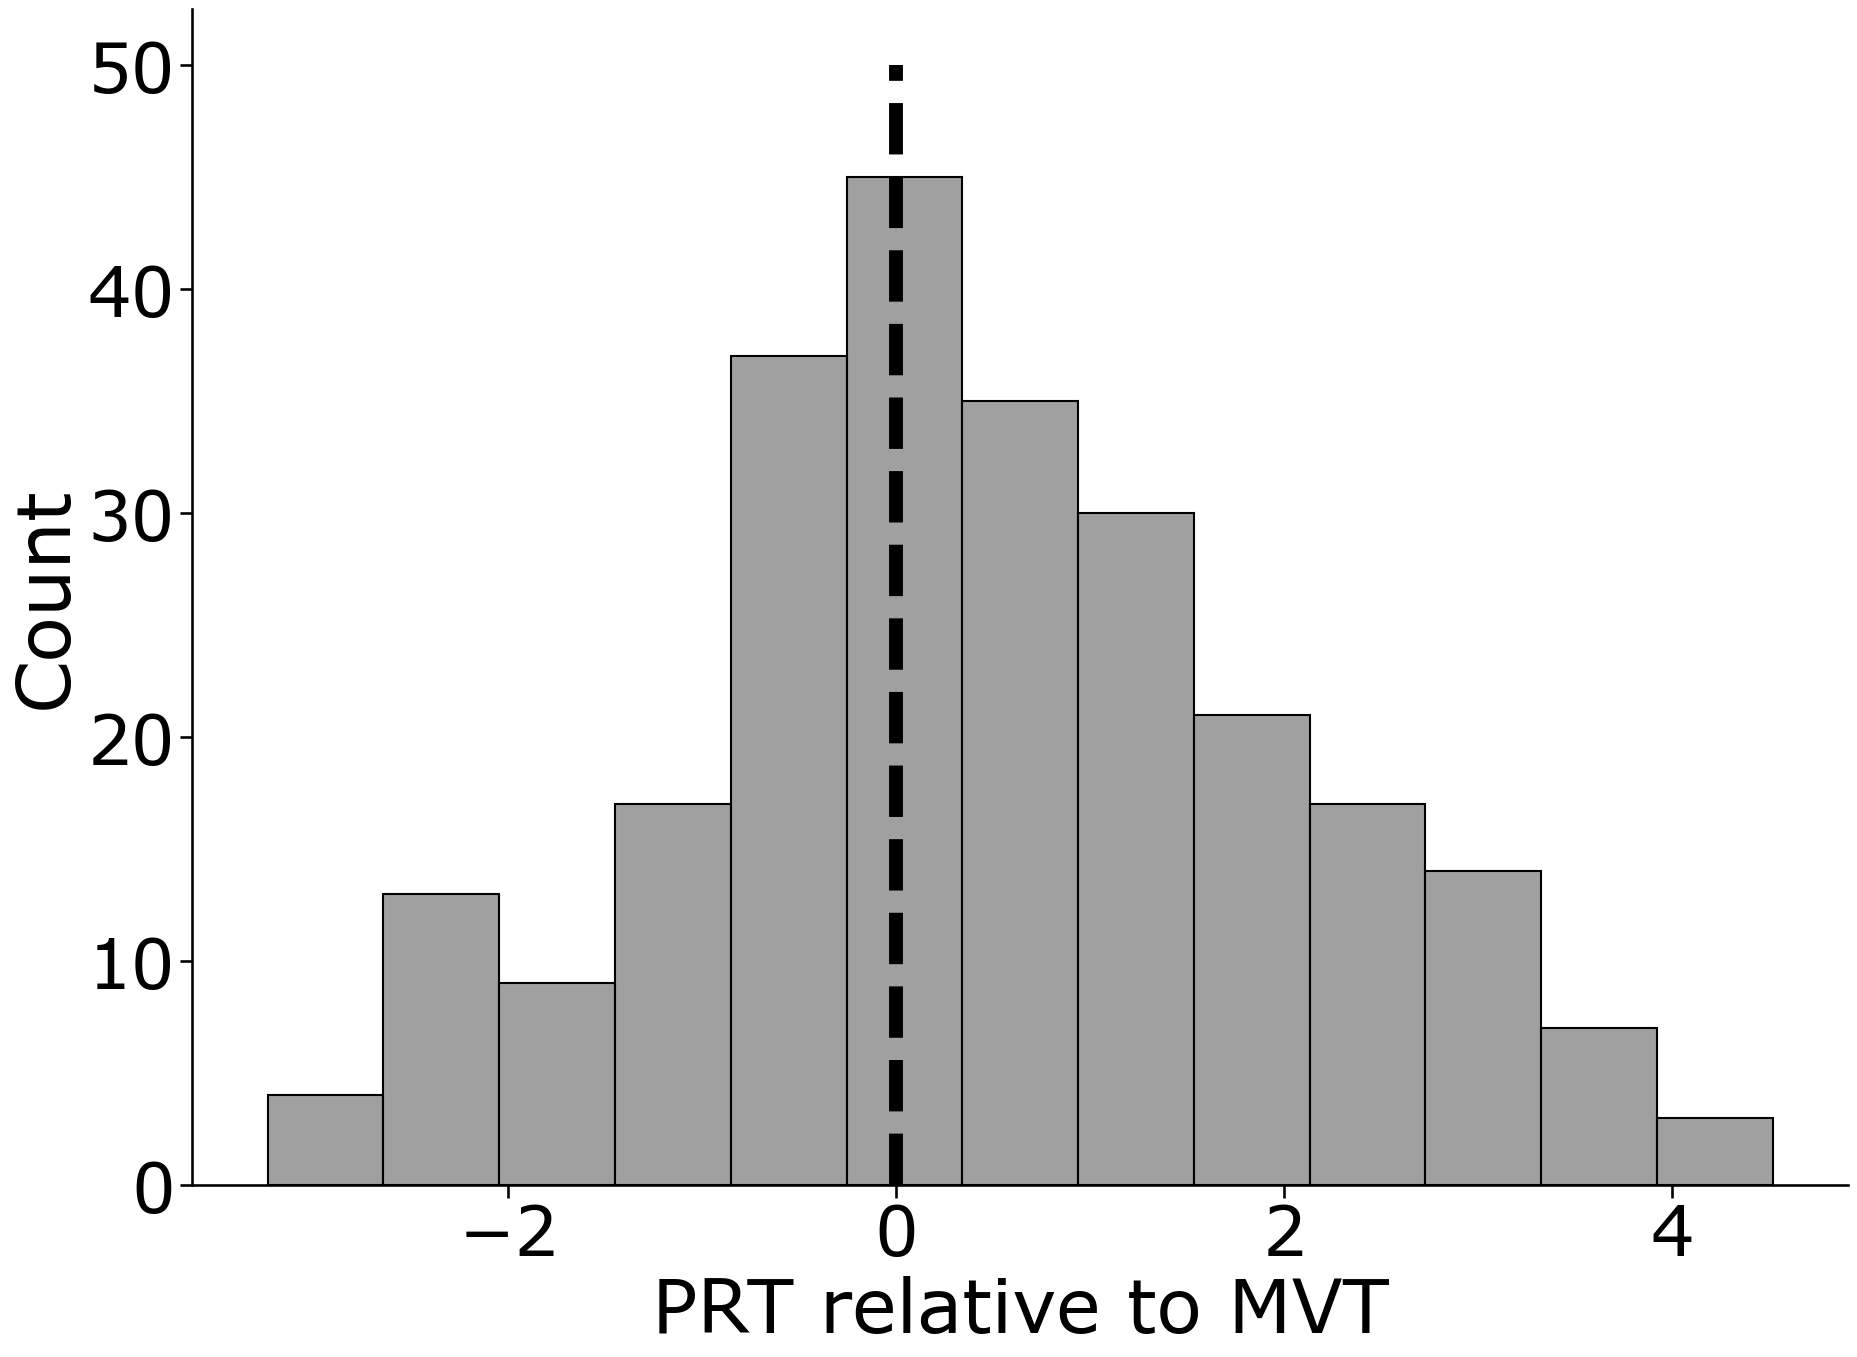

In [18]:
avgd_data = all_data.groupby(by=['sub_num','age','age_group']).mean().reset_index()

plt.rcParams["figure.figsize"] = (20,15)
sns.set_context('talk',font_scale=3)

sns.histplot(x='prt_rel_om',color='grey',data=avgd_data)
sns.despine(top=True,right=True)
plt.xlabel('PRT relative to MVT')
plt.plot([0,0],[0,50],'k--',linewidth=10)
plt.tight_layout()

if save_plots:
    plt.savefig('plots/overharvesting_overall.png')

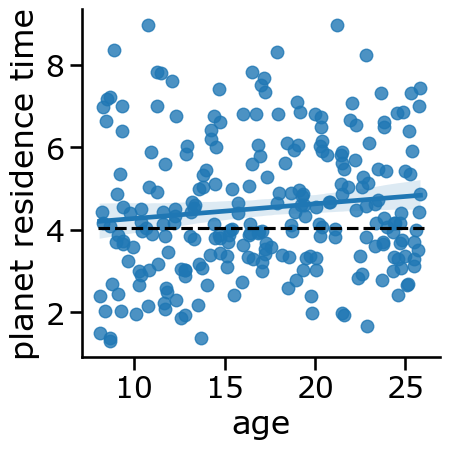

In [19]:
sns.set_context('talk',font_scale=1.3)
opt=np.mean(avgd_data.opt_prt_om)
g=sns.lmplot(x="age",y="prt",data=avgd_data)
g.set_ylabels("planet residence time")
plt.plot([8,26],[opt,opt],"k--")
if save_plots:
    plt.savefig('plots/planet_residence_time_v_age.png',bbox_inches = "tight",dpi=300)

#### Overharvesting by galaxy 

In [12]:
pal = sns.color_palette("Paired")
rbg_pal = [pal[5],pal[1],pal[3]]

/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/473283098.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgd_data = linear_df.groupby(by=['sub_num','galaxy','age_group']).mean().reset_index()
/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/473283098.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x="prt", y="age_group", order=['adults', 'adolescents', 'children'],data=data, ci=95, color="black", markers="d", join=False,scale=1.0, errwidth=3)
/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/473283098.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x="prt", y="age_group", order=['adults', 'adolesce

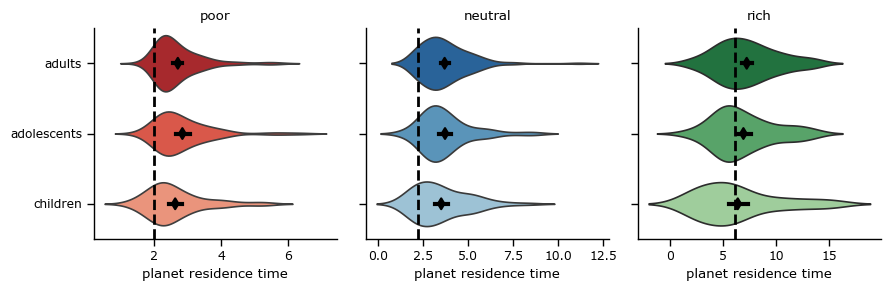

In [ ]:
poor_opt=np.mean(linear_df.query("galaxy=='poor'").opt_prt_om)
neut_opt=np.mean(linear_df.query("galaxy=='neutral'").opt_prt_om)
rich_opt=np.mean(linear_df.query("galaxy=='rich'").opt_prt_om)
sns.set_context('paper',font_scale=1.0)

avgd_data = linear_df.groupby(by=['sub_num','galaxy','age_group']).mean().reset_index()
avgd_data["age_group"] = avgd_data["age_group"].map({'child': "children", 'adolescent': "adolescents", 'adult': "adults"})
g=sns.FacetGrid(avgd_data,col="galaxy",col_order=['poor','neutral','rich'],sharex=False)

def plotter(data,**kwargs):
    galaxy=data.galaxy.unique()[0]

    if galaxy=='poor':
        pal=sns.color_palette("Reds_r",4)[:3]
        plt.axvline(poor_opt,color='k',linestyle='--',linewidth=2)
    elif galaxy=='neutral':
        pal=sns.color_palette("Blues_r",4)[:3] 
        plt.axvline(neut_opt,color='k',linestyle='--',linewidth=2)
    elif galaxy=='rich':
        pal=sns.color_palette("Greens_r",4)[:3] 
        plt.axvline(rich_opt,color='k',linestyle='--',linewidth=2)
    
    sns.violinplot(x="prt", y="age_group", order=['adults', 'adolescents', 'children'], palette=pal, inner=None, data=data, zorder=10)
    sns.pointplot(x="prt", y="age_group", order=['adults', 'adolescents', 'children'],data=data, ci=95, color="black", markers="d", join=False,scale=1.0, errwidth=3)
    plt.ylabel("")
    plt.xlabel("planet residence time")
    return 

g.map_dataframe(plotter)
g.set_titles("{col_name}")
if save_plots:
    plt.savefig('plots/prt_galaxy_age_group.png',bbox_inches = "tight",dpi=300)


### overharvesting by switch point 

/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/3859044901.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgd_data = linear_df.groupby(by=['sub_num','switch','age_group']).mean().reset_index()
/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/3859044901.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x="prt",y="switch",data=data, ci=95, color="black", markers="d",  order=['switch','no_switch'],join=False,scale=1.0, errwidth=3)
/var/folders/8d/qdt_mh0j1wz9k9rkvpqk7zv00000gq/T/ipykernel_96674/3859044901.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.pointplot(x="prt",y="switch",data=data, ci=95, color="black", markers="d", 

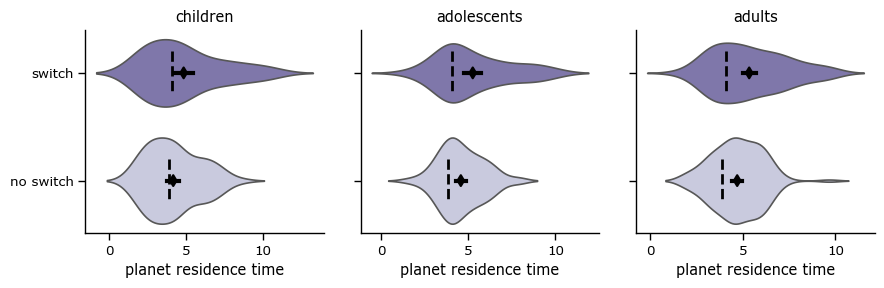

In [19]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('paper',font_scale=1.1)

no_swicth_opt=np.mean(linear_df.query("switch=='no_switch'").opt_prt_om)
switch_opt=np.mean(linear_df.query("switch=='switch'").opt_prt_om)

def plotter(data, **kwargs):
    type = data.switch.unique()[0]
    sns.violinplot(x="prt",y="switch",palette="Purples_r", order=['switch','no_switch'],inner=None,alpha=0.5,zorder=10,data=data)
    sns.pointplot(x="prt",y="switch",data=data, ci=95, color="black", markers="d",  order=['switch','no_switch'],join=False,scale=1.0, errwidth=3)
    plt.xlabel("planet residence time")
    plt.ylabel("")
    plt.plot([no_swicth_opt,no_swicth_opt],[0.8,1.2],'k--',linewidth=2)
    plt.plot([switch_opt,switch_opt],[-0.2,0.2],'k--',linewidth=2)
    #plt.plot([0.5,1.5],[switch_opt,switch_opt],'k--')

avgd_data = linear_df.groupby(by=['sub_num','switch','age_group']).mean().reset_index()
avgd_data["age_group"] = avgd_data["age_group"].map({'child': "children", 'adolescent': "adolescents", 'adult': "adults"})


g = sns.FacetGrid(avgd_data, col="age_group",sharex=False)
g.map_dataframe(plotter)
g.set_yticklabels(['switch','no switch'])
for ax in g.axes.flat:
    ax.set_xticks([0,5,10])
g.set_titles("{col_name}")
if save_plots:  
    plt.savefig('plots/switch_prt_age_group.png',bbox_inches = "tight",dpi=300)